# 1. Data Loading, Sampling and Cleaning

This section is for useful imports, packages and installation.

In [ ]:
#import
import bz2
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import re

In [ ]:
nltk.download('vader_lexicon')

In [ ]:
!pip install fasttext

In [ ]:
pd.__version__

Select first 10000 quotations of each year , and merge them with cleaned wikidata of speakers as a sample dataset. 

In [ ]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def load_quotebank(path_to_file, chunksize=1e4, samplesize=1e4) -> pd.DataFrame:
    """Load the first 10000 quotations of each year from quotebank dataset
    """
    data_quotebank = pd.DataFrame()
    cnt = 0
    numbatch = samplesize // chunksize
    for chunk in pd.read_json(path_to_file, lines=True, chunksize=chunksize):
        data_quotebank = data_quotebank.append(chunk)
        cnt = cnt + 1
        if cnt == numbatch:
            break
    return data_quotebank

In [ ]:
def clean_quotebank(data_quotebank) -> pd.DataFrame:
    """Clean quotebank dataset
    """
    # Get the columns we need
    data_quotebank = data_quotebank[['quoteID', 'quotation', 'date', 'numOccurrences', 'speaker', 'qids']].copy()
    # Remove the time in date
    data_quotebank.loc[:, 'date'] = data_quotebank['date'].astype('str')
    data_quotebank.loc[:, 'date'] = data_quotebank['date'].apply(lambda x: re.compile(r'\d{4}-\d{2}-\d{2}').findall(x)[0])
    # Remove data with unknown speakers
    data_quotebank.loc[data_quotebank['speaker'] == 'None', 'speaker'] = None
    data_quotebank.loc[data_quotebank['speaker'].isna(), 'qids'] = None
    # Remove redundant qids
    def get_first_qid(qids):
        try:
            return qids[0]
        except:
            return None
    # data_quotebank.loc[:, 'qids'] = pd.Series([sample[0] for sample in data_quotebank.qids])
    data_quotebank.loc[:, 'qids'] = data_quotebank['qids'].apply(get_first_qid)
    # data_quotebank_cleaned = data_quotebank
    data_quotebank = data_quotebank.rename(columns={'qids': 'id'})
    return data_quotebank

In [ ]:
def load_wiki(path_to_file) -> pd.DataFrame:
    """Load wikidata of speakers
    """
    data_wiki = pd.read_parquet(path_to_file)
    data_wiki = data_wiki[['id', 'label', 'party', 'aliases', 'date_of_birth', 'nationality', 'gender', 'ethnic_group', 'occupation', 'academic_degree', 'candidacy', 'religion']]
    return data_wiki

In [ ]:
def clean_wiki(data_wiki) -> pd.DataFrame:
    """Clean wikidata of speakers
    """
    # Remove rows with no party or no qids
    data_wiki_cleaned = data_wiki.dropna(axis=0, subset=['party', 'id']).reset_index(drop=True)
    return data_wiki_cleaned

In [ ]:
def merge(data_quotebank_cleaned, data_wiki_cleaned) -> pd.DataFrame:
    """Merge cleaned quotebank data and wikidata
    """
    data_merged = data_quotebank_cleaned.merge(right=data_wiki_cleaned, how='inner', on='id')
    return data_merged

## Loading

In [ ]:
quotes_2015 = load_quotebank('/content/drive/MyDrive/Quotebank/quotes-2015.json.bz2')
quotes_2016 = load_quotebank('/content/drive/MyDrive/Quotebank/quotes-2016.json.bz2')
quotes_2017 = load_quotebank('/content/drive/MyDrive/Quotebank/quotes-2017.json.bz2')
quotes_2018 = load_quotebank('/content/drive/MyDrive/Quotebank/quotes-2018.json.bz2')
quotes_2019 = load_quotebank('/content/drive/MyDrive/Quotebank/quotes-2019.json.bz2')
quotes_2020 = load_quotebank('/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2')

In [ ]:
quotes_2015 = clean_quotebank(quotes_2015)
quotes_2016 = clean_quotebank(quotes_2016)
quotes_2017 = clean_quotebank(quotes_2017)
quotes_2018 = clean_quotebank(quotes_2018)
quotes_2019 = clean_quotebank(quotes_2019)
quotes_2020 = clean_quotebank(quotes_2020)

# 2. Tokenization and word embedding

In this section, we split quotations into smaller tokens and allow those with similar meanings to have similar representations.

In [ ]:
import fasttext
import numpy as np

# quotation_text = open('quotation_text.txt', 'w', encoding='UTF-8')
# quotation_text.write(quotes_2015['quotation'].to_string(index=False))
# quotation_text.close()

with open('quotation_text.txt', 'w', encoding='UTF-8') as txt_writer:
    for i in range(len(quotes_2015['quotation'])):
        txt_writer.write(quotes_2015.loc[i, 'quotation'])

model = fasttext.train_unsupervised('quotation_text.txt', model = 'cbow')
vocabulary = model.words
word_embeddings = np.array([model[word] for word in vocabulary])

In [ ]:
print(word_embeddings.shape)

(3788, 100)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3788 samples in 0.032s...
[t-SNE] Computed neighbors for 3788 samples in 0.464s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3788
[t-SNE] Computed conditional probabilities for sample 2000 / 3788
[t-SNE] Computed conditional probabilities for sample 3000 / 3788
[t-SNE] Computed conditional probabilities for sample 3788 / 3788
[t-SNE] Mean sigma: 0.011878
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.198315
[t-SNE] KL divergence after 1000 iterations: 0.438058


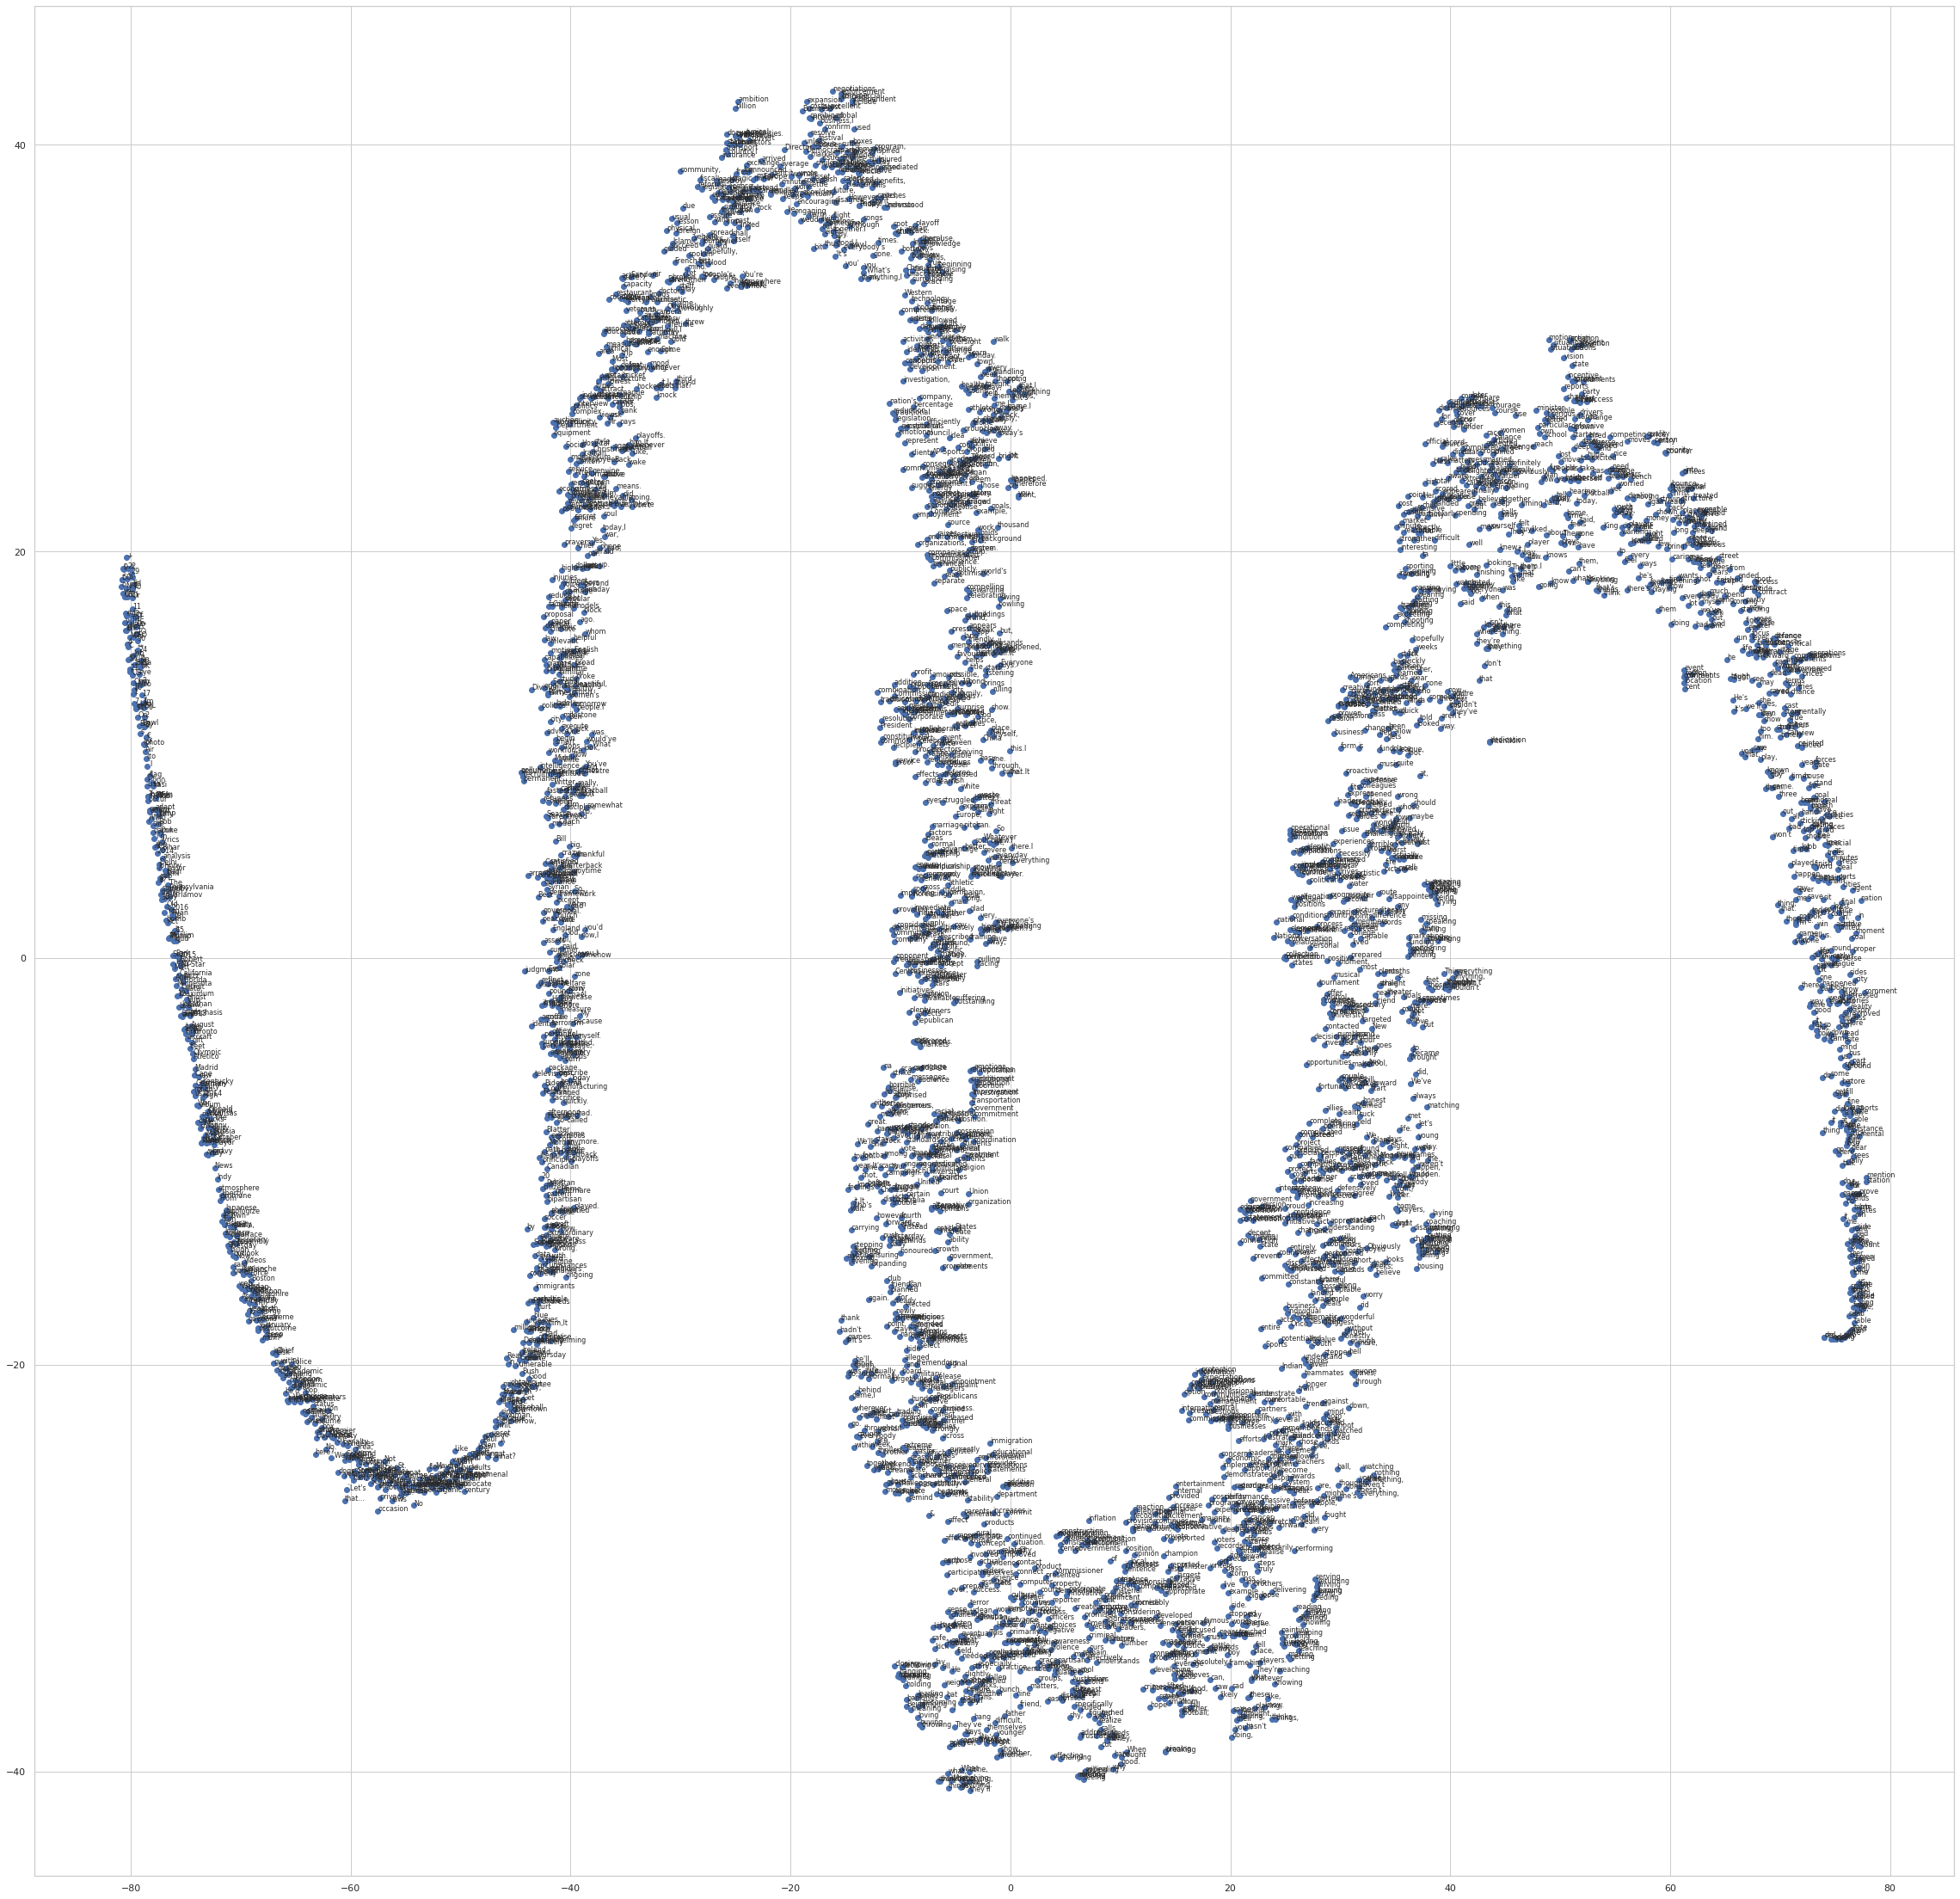

In [ ]:
# Visualize Embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import logging

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init = 'pca') # Changed the parameters for provided in the exercise for less KL divergence and better readibility

vis_data = tsne.fit_transform(word_embeddings)
vis_data_x = vis_data[:,0]
vis_data_y = vis_data[:,1]

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(40, 40)) 
plt.scatter(vis_data_x, vis_data_y)

for label, x, y in zip(vocabulary, vis_data_x, vis_data_y):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

# Basic Search Engine Using Word Embeddings

This section shows a simple search engine with the embedding we got in the previous part based on cosine distances. It is still a preliminary prototype and we are working to polish the searching results by feeding more data to the model.

In [ ]:
# Loading of libraries and documents
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
import math
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

# Create a dictionary of vectors for easier search
vector_dict = dict(zip(vocabulary, word_embeddings))
# original_documents = quotes_2015['quotation'].to_string(index=False)
original_documents = quotes_2015['quotation'].values

def aggregate_vector_list(vlist, aggfunc):
    if aggfunc == 'max':
        return np.array(vlist).max(axis=0)
    elif aggfunc == 'min':
        return np.array(vlist).min(axis=0)
    elif aggfunc == 'mean':
        return np.array(vlist).mean(axis=0)
    else:
        return np.zeros(np.array(vlist).shape[1])

possible_aggfuncs = ["max", "min", "mean"]

aggregated_doc_vectors = {}

# Aggregate vectors of documents beforehand
for aggfunc in possible_aggfuncs:
    aggregated_doc_vectors[aggfunc] = np.zeros((len(original_documents), word_embeddings.shape[1]))
    for index, doc in enumerate(original_documents):
        vlist = [vector_dict[token] for token in fasttext.tokenize(doc) if token in vector_dict]
        if(len(vlist) < 1):
            continue 
        else:
            aggregated_doc_vectors[aggfunc][index] = aggregate_vector_list(vlist, aggfunc) 

# Aggregate the query and find the most similar documents using cosine distance between the query's vector and document's aggregated vector
def aggregate_query(query, aggfunc):
    tokens = fasttext.tokenize(query)
    if(len(tokens) == 1):
        if(tokens[0] in vocabulary):
            return vector_dict[tokens[0]]
    elif(len(tokens) > 1):
        vlist = []
        for token in tokens:
            if (token in vocabulary):
                vlist.append(vector_dict[token])
        
        return aggregate_vector_list(vlist, aggfunc)
    else:
        print("%s is not in the vocabulary." % (query))
    
def get_most_similar_documents(query_vector, aggfunc, k=5):
    query_vector = query_vector.reshape(1, -1)
    # Calculate the similarity with each vector. 
    sim = cosine_similarity(query_vector, aggregated_doc_vectors[aggfunc])
    
    # Rank the document vectors according to their cosine similarity with
    indexes = np.argsort(sim, axis=-1, kind='quicksort', order=None) # This is sorted in ascending order
    indexes = indexes[0]
    indexes = indexes[::-1] # Convert to descending
    return indexes

def search_vec_embeddings(query, topk=10, aggfunc='mean'):
    query_vector = aggregate_query(query, aggfunc)
    indexes = get_most_similar_documents(query_vector, aggfunc)
    # Print the top k documents
    indexes = indexes[0:topk]
    for index in indexes:
        print(original_documents[index])
        print('\n')

In [ ]:
search_vec_embeddings('with', aggfunc='mean')

# 3. Speaker Wiki

This section is for testing the attribute 'party' of speaker dataset.

In [ ]:
wiki = load_wiki('/content/drive/MyDrive/Project datasets/speaker_attributes.parquet')
wiki_label = pd.read_csv('/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2')

In [ ]:
wiki = clean_wiki(wiki)
wiki.head(5)

,id,label,party,aliases,date_of_birth,nationality,gender,ethnic_group,occupation,academic_degree,candidacy,religion
0,Q23,George Washington,[Q327591],"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],None,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",None,"[Q698073, Q697949]",[Q682443]
1,Q207,George W. Bush,[Q29468],"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",None,"[Q327959, Q464075, Q3586276, Q4450587]","[Q329646, Q682443, Q33203]"
2,Q368,Augusto Pinochet,[Q327591],"[Augusto Pinochet Ugarte, Augusto José Ramón P...",[+1915-11-25T00:00:00Z],[Q298],[Q6581097],None,"[Q189290, Q82955]",None,None,[Q1841]
3,Q815,Gabriel Gonzáles Videla,[Q1759368],"[Gabriel González Videla, Gabriel Gonzales Vid...",[+1898-11-22T00:00:00Z],[Q298],[Q6581097],None,"[Q40348, Q193391, Q82955]",None,[Q1069391],None
4,Q873,Meryl Streep,[Q29552],"[Mary Louise Streep, Meryl Louise Streep, Stre...",[+1949-06-22T00:00:00Z],[Q30],[Q6581072],None,"[Q10800557, Q2259451, Q10798782, Q2405480, Q33...",None,None,[Q7066]


In [ ]:
def search_label(qid: str, labels: pd.DataFrame = wiki_label) -> str:
    """Search for the label of a given qid
    """
    try:
        label = labels[labels['QID'] == qid]['Label'].values[0]
    except:
        label = None
    return label

In [ ]:
wiki_party = wiki[['id', 'label', 'party']]
wiki_party

,id,label,party
0,Q23,George Washington,[Q327591]
1,Q207,George W. Bush,[Q29468]
2,Q368,Augusto Pinochet,[Q327591]
3,Q815,Gabriel Gonzáles Videla,[Q1759368]
4,Q873,Meryl Streep,[Q29552]
...,...,...,...
399171,Q106371401,Durga Tudu,[Q234277]
399172,Q106377030,None,[Q79854]
399173,Q106377068,Sunil De,[Q234277]
399174,Q106378203,Christine Roberts,[Q9630]


In [ ]:
quotes_party_2015 = merge(quotes_2015, wiki_party[['id', 'party']])
quotes_party_2016 = merge(quotes_2016, wiki_party[['id', 'party']])
quotes_party_2017 = merge(quotes_2017, wiki_party[['id', 'party']])
quotes_party_2018 = merge(quotes_2018, wiki_party[['id', 'party']])
quotes_party_2019 = merge(quotes_2019, wiki_party[['id', 'party']])
quotes_party_2020 = merge(quotes_2020, wiki_party[['id', 'party']])

In [ ]:
def clean_quotes_party(quotes_party):
    def get_first_qid(qids):
        try:
            return qids[0]
        except:
            return None
    quotes_party.loc[:, 'party'] = quotes_party['party'].apply(get_first_qid)
    return quotes_party

In [ ]:
quotes_party_2015 = clean_quotes_party(quotes_party_2015)
quotes_party_2016 = clean_quotes_party(quotes_party_2016)
quotes_party_2017 = clean_quotes_party(quotes_party_2017)
quotes_party_2018 = clean_quotes_party(quotes_party_2018)
quotes_party_2019 = clean_quotes_party(quotes_party_2019)
quotes_party_2020 = clean_quotes_party(quotes_party_2020)

In [ ]:
quotes_party_2015.head(10)

,quoteID,quotation,date,numOccurrences,speaker,id,party
0,2015-08-31-000271,... a great day for veterans here in Littleton...,2015-08-31,2,Jeanne Shaheen,Q270316,Q29552
1,2015-10-04-000115,[ Ban ] recalls that hospitals and medical per...,2015-10-04,2,Ban Ki-moon,Q1253,Q327591
2,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",2015-10-25,1,Bernie Sanders,Q359442,Q6542163
3,2015-10-15-015673,But if you talk about why the middle class is ...,2015-10-15,1,Bernie Sanders,Q359442,Q6542163
4,2015-04-15-038299,"If they destroy you, who is there left?",2015-04-15,1,Bernie Sanders,Q359442,Q6542163
5,2015-07-30-060129,It would make everybody in America poorer.,2015-07-30,13,Bernie Sanders,Q359442,Q6542163
6,2015-10-14-073757,"labor is the source of all wealth,",2015-10-14,1,Bernie Sanders,Q359442,Q6542163
7,2015-10-14-074474,Let me say something that may not be great pol...,2015-10-14,1,Bernie Sanders,Q359442,Q6542163
8,2015-04-21-040961,"No, it's America,",2015-04-21,1,Bernie Sanders,Q359442,Q6542163
9,2015-09-20-040134,People should be elected to office based on th...,2015-09-20,18,Bernie Sanders,Q359442,Q6542163


In [ ]:
quotes_party_six_years = pd.concat([quotes_party_2015, quotes_party_2016, quotes_party_2017, quotes_party_2018, quotes_party_2019, quotes_party_2020])

In [ ]:
def get_party_count(quotes_party):
    party_count = quotes_party[['id', 'party']].groupby('party').agg('count').sort_values('id', ascending=False).reset_index()
    party_count = party_count.rename(columns={'id': 'count'})
    party_count['label'] = party_count['party'].apply(search_label)
    return party_count

In [ ]:
party_count_six_years = get_party_count(quotes_party_six_years)
party_count_six_years

,party,count,label
0,Q29468,2457,Republican Party
1,Q29552,2346,Democratic Party
2,Q10230,330,Bharatiya Janata Party
3,Q9626,260,Conservative Party
4,Q10225,193,Indian National Congress
...,...,...,...
570,Q3130920,1,National Rainbow Coalition
571,Q308714,1,Communist Party USA
572,Q304191,1,National Coalition Party
573,Q300093,1,"Party for Labour, Environment and Family"


In [ ]:
search_label('Q1897793', wiki_label)

'Independence Party of America'

# 4. Preliminary sentiment analysis

In this section, we test preliminary sentiment analysis to the quotations using dictionaries from nltk, score them and divide them into 'Negative'， 'Neutral' and 'Positive'.


In [ ]:
class SentimentCalculator:
    def __init__(self) -> None:
        self._sid = SentimentIntensityAnalyzer()

    def sentiment_score(self, quote: str) -> float:
        full_score = self._sid.polarity_scores(quote)
        return full_score['compound']

In [ ]:
sc = SentimentCalculator()

In [ ]:
sentiment_2015 = quotes_2015['quotation'].apply(sc.sentiment_score)
sentiment_2016 = quotes_2016['quotation'].apply(sc.sentiment_score)
sentiment_2017 = quotes_2017['quotation'].apply(sc.sentiment_score)
sentiment_2018 = quotes_2018['quotation'].apply(sc.sentiment_score)
sentiment_2019 = quotes_2019['quotation'].apply(sc.sentiment_score)
sentiment_2020 = quotes_2020['quotation'].apply(sc.sentiment_score)

In [ ]:
def get_attitude(score):
    if score >= 0.05:
        return 'POSITIVE'
    elif score <= -0.05:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'

In [ ]:
sentiment_2015_label = sentiment_2015.apply(get_attitude)
sentiment_2016_label = sentiment_2016.apply(get_attitude)
sentiment_2017_label = sentiment_2017.apply(get_attitude)
sentiment_2018_label = sentiment_2018.apply(get_attitude)
sentiment_2019_label = sentiment_2019.apply(get_attitude)
sentiment_2020_label = sentiment_2020.apply(get_attitude)
sentiment_2015_label

0       POSITIVE
1        NEUTRAL
2       NEGATIVE
3        NEUTRAL
4       NEGATIVE
          ...   
9995    NEGATIVE
9996    POSITIVE
9997    POSITIVE
9998     NEUTRAL
9999     NEUTRAL
Name: quotation, Length: 10000, dtype: object

# 5. Visualization
in this section, we analysis the basic info of the general data and investigate the influence of party to their sentiment.

In [ ]:
#visualization
#1. reorganize the dataset for futher analysis:
# 1.1 generate the full dataset with the speaker, party and sentiment
quotes_2015['Year']='2015'
quotes_2016['Year']='2016'
quotes_2017['Year']='2017'
quotes_2018['Year']='2018'
quotes_2019['Year']='2019'
quotes_2020['Year']='2020'
quotes_six_years = pd.concat([quotes_2015,quotes_2016,quotes_2017,quotes_2018,quotes_2019,quotes_2020])
sentiment_six_years = pd.concat([sentiment_2015_label,sentiment_2016_label,sentiment_2017_label,sentiment_2018_label,sentiment_2019_label,sentiment_2020_label])
quotes_six_years['Sentiment'] = sentiment_six_years
                

In [ ]:
quotes_six_years.head(5)
quotes_with_sentiment = pd.merge(quotes_party_six_years,quotes_six_years[['quoteID','Sentiment','Year']],on='quoteID',how='inner')
print(quotes_with_sentiment.shape[0])
print(quotes_with_sentiment.columns)

9172
Index(['quoteID', 'quotation', 'date', 'numOccurrences', 'speaker', 'id',
       'party', 'Sentiment', 'Year'],
      dtype='object')


In [ ]:
#1.2 becasue the searching engine mentioned before is not yet working well, we select the topic about the environment using re module in python 
keywords = ['climate','CO2 emission','emission of C02','CO2','greenhouse','global warm']
def is_in(full_str, sub_str):
    if re.findall(sub_str, full_str):
        return True
    else:
        return False
def is_climate(series):
  full_str = series['quotation']
  results = [is_in(full_str,x) for x in keywords]
  if True in results:
    return True
  else:
    return False
quotes_with_sentiment['is_climate'] = quotes_with_sentiment.apply(is_climate,axis=1)
quotes_climate = quotes_with_sentiment[quotes_with_sentiment['is_climate']==True]




In [ ]:
#2. visualize the results from multiple aspects:
party_count = quotes_with_sentiment[['quoteID','Year']].groupby('Year').agg('count').reset_index()
party_count.rename(columns={'quoteID':'count'},inplace=True)

Text(0.5, 1.0, 'most frequent quoted speakers')

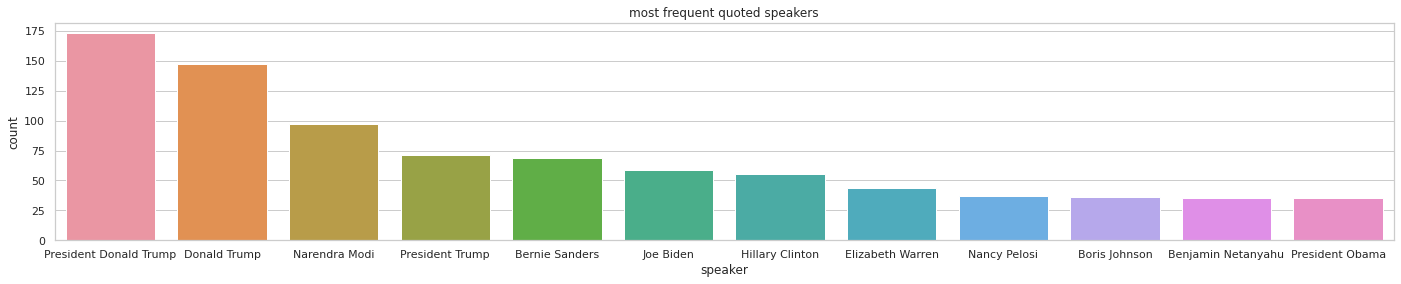

In [ ]:
  #2.1 top 10 speakers:
  top_speakers = quotes_with_sentiment[['quoteID','speaker']].groupby('speaker').agg('count').sort_values('quoteID', ascending=False).reset_index()
  top_speakers.rename(columns={'quoteID':'count'},inplace=True)
  top_10_speakers = top_speakers.iloc[0:12]
  #add 0,1,3 together due to overlap
  sns.set_theme(style="whitegrid")
  fig_dims = (24, 4)
  fig, ax = plt.subplots(figsize=fig_dims)
  p = sns.barplot(x='speaker',y='count',data=top_10_speakers)
  p.set_title('most frequent quoted speakers')

Text(0.5, 1.0, 'most frequently quoted party')

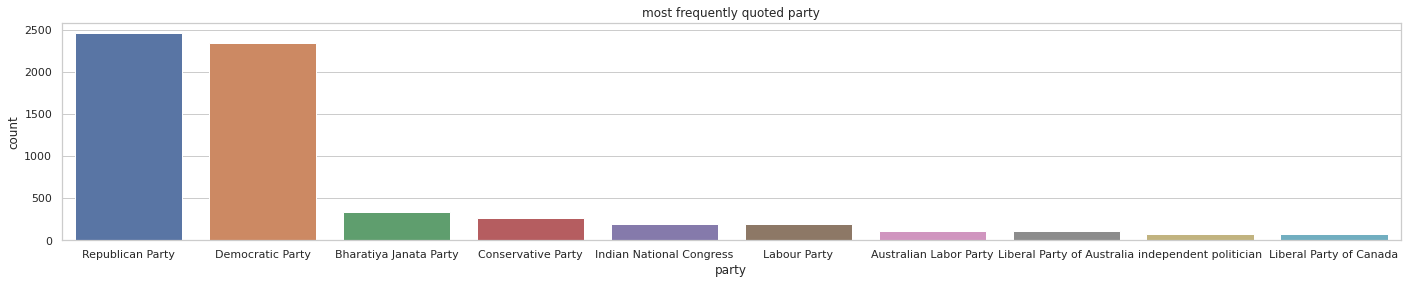

In [ ]:
#2.2 party distribution:
party_count = quotes_with_sentiment[['quoteID','party']].groupby('party').agg('count').sort_values('quoteID', ascending=False).reset_index()
party_count.rename(columns={'quoteID':'count'},inplace=True)

party_count['party']=party_count.apply(lambda x:search_label(x['party'],wiki_label),axis=1)
fig_dims = (24, 4)
fig, ax = plt.subplots(figsize=fig_dims)
p = sns.barplot(x='party',y='count',data=party_count.iloc[0:10,:])
p.set_title('most frequently quoted party')

In [ ]:
#2.3 a naive presentation of calculating 'political support rate':
#overall support rate change throughout the years
tmp_list = []
for idx,tmp in quotes_climate.groupby('Year'):
  approval_rate = tmp[tmp['Sentiment']=='POSITIVE'].shape[0]/tmp.shape[0]
  tmp_list.append(approval_rate)
print(tmp_list)

[0.6666666666666666, 0.5, 0.3333333333333333, 0.5, 0.5, 0.2222222222222222]


Text(0.5, 1.0, 'positive percentage throughout the year')

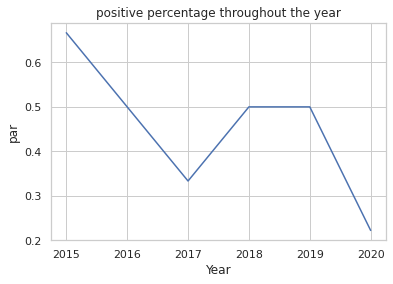

In [ ]:
sentiment_change = pd.DataFrame({'Year':['2015','2016','2017','2018','2019','2020'],'par':tmp_list})
p = sns.lineplot(x='Year',y='par',data=sentiment_change)
p.set_title('positive percentage throughout the year')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


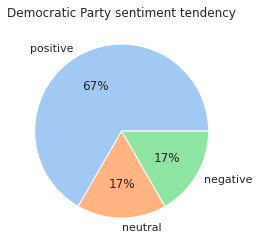

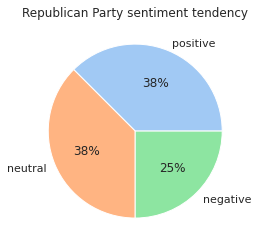

In [ ]:
#2.4 different party's attitude:
quotes_climate['party'] = quotes_climate.apply(lambda x:search_label(x['party'],wiki_label),axis=1)
#print(quotes_climate['party'])
#democratic party:
democratic_anal = quotes_climate[quotes_climate['party']=='Democratic Party']

colors = sns.color_palette('pastel')[0:3]
plt.pie([democratic_anal[democratic_anal['Sentiment']=='POSITIVE'].shape[0],democratic_anal[democratic_anal['Sentiment']=='NEUTRAL'].shape[0],democratic_anal[democratic_anal['Sentiment']=='NEGATIVE'].shape[0]], labels = ['positive','neutral','negative'], colors = colors, autopct='%.0f%%')
plt.title('Democratic Party sentiment tendency')
plt.show()

#Republican party:

republican_anal = quotes_climate[quotes_climate['party']=='Republican Party']
plt.pie([republican_anal[republican_anal['Sentiment']=='POSITIVE'].shape[0],republican_anal[republican_anal['Sentiment']=='NEUTRAL'].shape[0],republican_anal[republican_anal['Sentiment']=='NEGATIVE'].shape[0]], labels = ['positive','neutral','negative'], colors = colors, autopct='%.0f%%')
plt.title('Republican Party sentiment tendency')
plt.show()
